In [1]:
# -*- coding: utf-8 -*-
import sys, os
import numpy as np
import pandas as pd
import cobra
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams.update({'mathtext.default': 'regular'})
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['savefig.bbox'] = 'tight'

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.5
pandas version: 1.2.0
cobrapy version: 0.20.0 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.5
pandas version: 1.2.0
cobrapy version: 0.20.0


In [2]:
def KORxn(model: cobra.Model,
          rxns2KO: list):
    """Function for knocking out reactions."""
    for ID in rxns2KO:
        reaction = model.reactions.get_by_id(ID)
        reaction.knock_out()

In [3]:
def pfba(model: cobra.Model):
    cobra.flux_analysis.pfba(model)

In [4]:
def flux2file(model: cobra.Model, 
              psw, product, output_dir='tmp'):
    """Function of exporting flux data."""
    n = len(model.reactions)
    modelMatrix = np.empty([n, 9], dtype = object)
    for i in range(len(model.reactions)):
        x = model.reactions[i]
        modelMatrix[i, 0] = i + 1
        modelMatrix[i, 1] = x.id
        modelMatrix[i, 2] = x.name
        modelMatrix[i, 3] = x.reaction
        modelMatrix[i, 4] = x.subsystem
        modelMatrix[i, 5] = x.lower_bound
        modelMatrix[i, 6] = x.upper_bound
        modelMatrix[i, 7] = x.flux
        modelMatrix[i, 8] = abs(x.flux)
        
    df = pd.DataFrame(data = modelMatrix, 
                      columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                      'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    filepath = os.path.join(output_dir, '{}_{}.xlsx'.format(psw, product))
    df.to_excel(filepath, index=False)

 ## Model background

  * Using _E. coli_ full model *i*ML1515.
  * Modified the transhydrogenase reaction (THD2pp) from 2 protons translocation to 1.
  * Changed HSDy (homoserine DH) to be irrversible, towards to homS.
  * Changed ICL (isocitrate lyase) to be reversible.
  * Changed TRPAS2 (Tryptophanase) to be irreversible, towards tryptophane degradation.
  * Base deletions: PFL, OBTFL, POR5 (pyruvate synthase, Ferredoxin), FDH4pp, FDH5pp, GLYCK (glycerate kinase, to 3pg), FRD2 and FRD3.
  * FolD is reversible, MTHFC and MTHFD, equivalent to Fch and MtdA.
  * FTL reaction is existed, FTHFLi (irrversible)
  * GlyA (GHMT2r) is reversible.
  * The model has a sarcosine oxidase reaction (SARCOX, solA), but no sarcosine exchange.


In [5]:
# Load full model and modification 
model = cobra.io.load_json_model(r'..\0_ecoli_models\iML1515.json')

model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1})
model.reactions.HSDy.bounds = (-1000, 0)
model.reactions.ICL.bounds = (-1000, 1000)
model.reactions.TRPAS2.bounds = (0, 1000)

wt = model.copy()

KORxn_base = ['POR5', 'GLYCK', 'FDH4pp', 'FDH5pp',
              'PFL', 'OBTFL', 'GART', 'DRPA', 'PAI2T',
              'FRD2','FRD3',]

KORxn(model, KORxn_base)

model.reactions.EX_glc__D_e.bounds = (0,0)

# rxn=cobra.Reaction(id='EX_sarcs',name='Sarcosine exchange',lower_bound=0,upper_bound=0)
# model.add_reaction(rxn)
# rxn.add_metabolites({'sarcs_c':-1})

 ## RuMP sensor

In [6]:
rump = model.copy()

h6p_c = cobra.Metabolite(
    'h6p_c',
    formula='C6H11O9P',
    name='arabino-3-hexulose 6-phosphate',
    compartment='c'
)

rxn=cobra.Reaction(id='HPS',name='3-hexulose-6-phosphate synthase',lower_bound=-1000,upper_bound=1000)
rump.add_reaction(rxn)
rxn.add_metabolites({'ru5p__D_c':-1,'fald_c':-1,h6p_c:1})

rxn=cobra.Reaction(id='PHI',name='6-phospho-3-hexuloisomerase',lower_bound=-1000,upper_bound=1000)
rump.add_reaction(rxn)
rxn.add_metabolites({h6p_c:-1,'f6p_c':1})

KO_rump = [
    'FALDH2',  # frmA
    'TKT1','TKT2',
    'FBP',  # fbp, glpX
    'G6PDH2r',  # zwf
]
KORxn(rump,KO_rump)

rump.reactions.EX_xyl__D_e.lower_bound = -1000
rump.reactions.EX_succ_e.lower_bound = -1000

# E4P source 
rxn=cobra.Reaction(id='EX_E4P',name='EX E4P',lower_bound=-1000,upper_bound=0)
rump.add_reaction(rxn)
rxn.add_metabolites({'e4p_c':-1})

In [7]:
# check growth without sarcosine/formaldehyde first 
with rump as m: 
    # need to KO F6PA: dha + g3p <=> f6 to create the sensor strain 
    m.reactions.F6PA.knock_out()
    pfba(m)
    print(m.summary())
    # flux2file(m,'rump','0')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.0

Uptake
------
Metabolite  Reaction Flux  C-Number  C-Flux
       h_e    EX_h_e 1.12         0   0.00%
      o2_e   EX_o2_e 1.96         0   0.00%
    succ_e EX_succ_e 0.56         4 100.00%

Secretion
---------
Metabolite Reaction  Flux  C-Number  C-Flux
     co2_e EX_co2_e -2.24         1 100.00%
     h2o_e EX_h2o_e -1.68         0   0.00%




In [8]:
with rump as m: 
    # m.reactions.EX_sarcs.lower_bound = -1
    m.reactions.EX_fald_e.lower_bound = -1
    m.reactions.F6PA.knock_out()
    print(m.summary())
    # flux2file(m,'rump','1')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 10.583354500042194

Uptake
------
Metabolite     Reaction      Flux  C-Number C-Flux
     e4p_c       EX_E4P     4.036         4  1.84%
     ca2_e     EX_ca2_e   0.05509         0  0.00%
      cl_e      EX_cl_e   0.05509         0  0.00%
 cobalt2_e EX_cobalt2_e 0.0002646         0  0.00%
     cu2_e     EX_cu2_e  0.007504         0  0.00%
    fald_e    EX_fald_e         1         1  0.11%
     fe2_e     EX_fe2_e   0.08734         0  0.00%
     fe3_e     EX_fe3_e   0.08263         0  0.00%
       h_e       EX_h_e       299         0  0.00%
       k_e       EX_k_e     2.066         0  0.00%
     mg2_e     EX_mg2_e   0.09181         0  0.00%
     mn2_e     EX_mn2_e  0.007313         0  0.00%
    mobd_e    EX_mobd_e 7.408E-05         0  0.00%
     nh4_e     EX_nh4_e     114.3         0  0.00%
     ni2_e     EX_ni2_e  0.003418         0  0.00%
      o2_e      EX_o2_e     308.7         0  0.00%
      pi_e      EX_pi_e     6.173         0  0.00%
 

 When formaldehyde uptake is the constraint to the growth,
 the slope between the minimum required formaldehyde uptake rate (y-axis) and growth rate (x-axis)
 is the formaldehyde requirements/dependency of the model, i.e.,
 $$\dfrac{mmol/gCDW/h}{1/h} = \dfrac{mmol}{gCDW}$$

In [9]:
data = pd.DataFrame(
    columns=['Growth rate','FALD uptake'],
    dtype=float,
)
data['Growth rate'] = np.arange(0.5,step=0.1)

def req_calc(
        model: cobra.Model,
        df: pd.DataFrame,
        strain: str
):
    model.reactions.EX_fald_e.lower_bound = -1000
    model.objective ={model.reactions.EX_fald_e:-1}
    model.objective_direction='min'

    for i in df.index: 
        gr = df.loc[i,'Growth rate']
        # print(gr)
        model.reactions.BIOMASS_Ec_iML1515_core_75p37M.bounds = (gr,gr)
        pfba(model)
        # print(model.summary())
        df.loc[i,'FALD uptake'] = abs(model.reactions.EX_fald_e.flux)

    slope = (df.iloc[4,1]-df.iloc[0,1])/(df.iloc[4,0]-df.iloc[0,0])

    fig, ax = plt.subplots(figsize=(5,5))
    sns.lineplot(
        x='Growth rate',y='FALD uptake',data=df,
        marker='o',ax=ax,
    )
    ax.fill_between(
        x=df['Growth rate'],y1=0.5,y2=df['FALD uptake'],
        facecolor='b',alpha=0.5,
    )
    plt.setp(
        ax,xlim=(0,0.4),ylim=(0,0.5),
        xlabel='Growth rate (1/h)',
        ylabel='FALD uptake rate (mmol/gCDW/h)',
        title=f'{strain}\n slope={slope:.3f} mmol/gCDW',
    )
    plt.savefig(f'{strain} FALD dependecy.pdf')

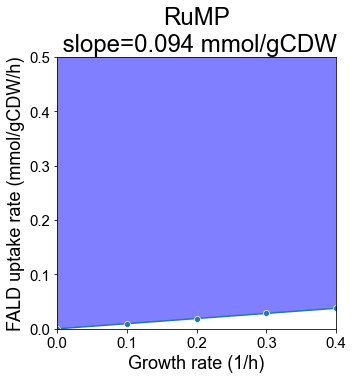

In [10]:
with rump as m:
    m.reactions.F6PA.knock_out()
    rump_df = data.copy()
    req_calc(m,rump_df,'RuMP')

 ## LtaE sensor

In [11]:
ltaE = model.copy()

rxn=cobra.Reaction(id='SAL',name='serine aldolase',lower_bound=-1000,upper_bound=1000)
ltaE.add_reaction(rxn)
rxn.add_metabolites({'gly_c':-1,'fald_c':-1,'ser__L_c':1})

KO_ltaE = [
    'FALDH2',  # frmA
    'AHGDx','PGCD', # serA
    'GHMT2r','THFAT'  # glyA
]
KORxn(ltaE,KO_ltaE)

ltaE.reactions.EX_glc__D_e.lower_bound = -1000
ltaE.reactions.EX_gly_e.lower_bound = -1000

In [12]:
# check growth without sarcosine/formaldehyde first 
with ltaE as m: 
    pfba(m)
    print(m.summary())
    # flux2file(m,'ltaE','0')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.0

Uptake
------
Metabolite    Reaction   Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e 0.2919         6 100.00%
      o2_e     EX_o2_e  1.751         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -1.751         1 100.00%
     h2o_e EX_h2o_e -1.751         0   0.00%




In [13]:
with ltaE as m: 
    m.reactions.EX_fald_e.lower_bound = -1
    print(m.summary())
    # flux2file(m,'ltaE','1')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 1.517116871098169

Uptake
------
Metabolite     Reaction      Flux  C-Number C-Flux
     ca2_e     EX_ca2_e  0.007897         0  0.00%
      cl_e      EX_cl_e  0.007897         0  0.00%
 cobalt2_e EX_cobalt2_e 3.793E-05         0  0.00%
     cu2_e     EX_cu2_e  0.001076         0  0.00%
    fald_e    EX_fald_e         1         1  0.95%
     fe2_e     EX_fe2_e   0.02437         0  0.00%
  glc__D_e  EX_glc__D_e     15.99         6 90.75%
     gly_e     EX_gly_e      4.39         2  8.31%
       k_e       EX_k_e    0.2961         0  0.00%
     mg2_e     EX_mg2_e   0.01316         0  0.00%
     mn2_e     EX_mn2_e  0.001048         0  0.00%
    mobd_e    EX_mobd_e 1.062E-05         0  0.00%
     nh4_e     EX_nh4_e     11.99         0  0.00%
     ni2_e     EX_ni2_e   0.00049         0  0.00%
      o2_e      EX_o2_e     36.24         0  0.00%
      pi_e      EX_pi_e     1.463         0  0.00%
     so4_e     EX_so4_e     0.382         0  0.00%
  

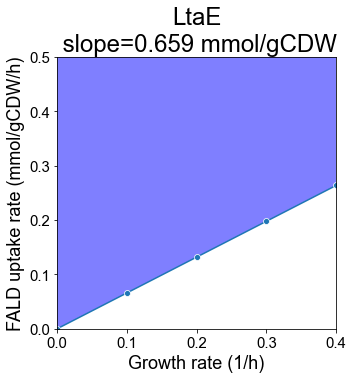

In [14]:
with ltaE as m:
    ltaE_df = data.copy()
    req_calc(m,ltaE_df,'LtaE')

 ## HAL sensor

In [15]:
HAL = model.copy()

hob_c = cobra.Metabolite(
    'hob_c',
    formula='C4H5O4',
    name='4-hydroxy-2-oxobutanoate',
    compartment='c'
)

rxn=cobra.Reaction(id='HAL',name='HOB aldolase',lower_bound=-1000,upper_bound=1000)
HAL.add_reaction(rxn)
rxn.add_metabolites({'pyr_c':-1,'fald_c':-1,hob_c:1})

rxn=cobra.Reaction(id='HAT',name='HOB aminotransferase',lower_bound=-1000,upper_bound=1000)
HAL.add_reaction(rxn)
rxn.add_metabolites({hob_c:-1,'glu__L_c':-1,'hom__L_c':1,'akg_c':1})

KO_hal = [
    'FALDH2',  # frmA
    'ASAD', # asd
]
KORxn(HAL,KO_hal)

HAL.reactions.EX_glc__D_e.lower_bound = -1000
HAL.reactions.EX_26dap__M_e.lower_bound = -1000

In [16]:
# check growth without sarcosine/formaldehyde first 
with HAL as m: 
    pfba(m)
    print(m.summary())
    # flux2file(m,'HAL','0')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.0

Uptake
------
Metabolite    Reaction   Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e 0.2919         6 100.00%
      o2_e     EX_o2_e  1.751         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -1.751         1 100.00%
     h2o_e EX_h2o_e -1.751         0   0.00%




In [17]:
with HAL as m: 
    m.reactions.EX_fald_e.lower_bound = -1
    print(m.summary())
    # flux2file(m,'HAL','1')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 1.4324041327724042

Uptake
------
Metabolite      Reaction      Flux  C-Number C-Flux
26dap__M_e EX_26dap__M_e    0.5313         7  3.81%
     ca2_e      EX_ca2_e  0.007456         0  0.00%
      cl_e       EX_cl_e  0.007456         0  0.00%
 cobalt2_e  EX_cobalt2_e 3.581E-05         0  0.00%
     cu2_e      EX_cu2_e  0.001016         0  0.00%
    fald_e     EX_fald_e         1         1  1.02%
     fe2_e      EX_fe2_e   0.02301         0  0.00%
  glc__D_e   EX_glc__D_e     15.49         6 95.17%
       k_e        EX_k_e    0.2796         0  0.00%
     mg2_e      EX_mg2_e   0.01243         0  0.00%
     mn2_e      EX_mn2_e 0.0009898         0  0.00%
    mobd_e     EX_mobd_e 1.003E-05         0  0.00%
     nh4_e      EX_nh4_e     14.41         0  0.00%
     ni2_e      EX_ni2_e 0.0004627         0  0.00%
      o2_e       EX_o2_e     34.15         0  0.00%
      pi_e       EX_pi_e     1.382         0  0.00%
     so4_e      EX_so4_e    0.3607 

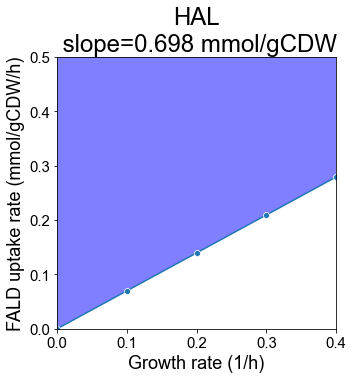

In [18]:
with HAL as m: 
    HAL_df = data.copy()
    req_calc(m,HAL_df,'HAL')

 ## HAL with Thr

In [19]:
with HAL as m: 
    m.reactions.EX_thr__L_e.lower_bound = -1000
    pfba(m)
    print(m.summary())
    # flux2file(m,'HAL_Thr','0')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.0

Uptake
------
Metabolite    Reaction   Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e 0.2919         6 100.00%
      o2_e     EX_o2_e  1.751         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -1.751         1 100.00%
     h2o_e EX_h2o_e -1.751         0   0.00%




In [20]:
with HAL as m: 
    m.reactions.EX_thr__L_e.lower_bound = -1000
    m.reactions.EX_fald_e.lower_bound = -1
    print(m.summary())
    # flux2file(m,'HAL_Thr','1')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 6.497261404318084

Uptake
------
Metabolite      Reaction      Flux  C-Number C-Flux
26dap__M_e EX_26dap__M_e      2.41         7  3.63%
     ca2_e      EX_ca2_e   0.03382         0  0.00%
      cl_e       EX_cl_e   0.03382         0  0.00%
 cobalt2_e  EX_cobalt2_e 0.0001624         0  0.00%
     cu2_e      EX_cu2_e  0.004607         0  0.00%
    fald_e     EX_fald_e         1         1  0.22%
     fe2_e      EX_fe2_e    0.1044         0  0.00%
  glc__D_e   EX_glc__D_e     30.89         6 39.89%
       k_e        EX_k_e     1.268         0  0.00%
     mg2_e      EX_mg2_e   0.05636         0  0.00%
     mn2_e      EX_mn2_e   0.00449         0  0.00%
    mobd_e     EX_mobd_e 4.548E-05         0  0.00%
     ni2_e      EX_ni2_e  0.002099         0  0.00%
      o2_e       EX_o2_e     163.1         0  0.00%
      pi_e       EX_pi_e     6.267         0  0.00%
     so4_e      EX_so4_e     1.636         0  0.00%
  thr__L_e   EX_thr__L_e     65.35  

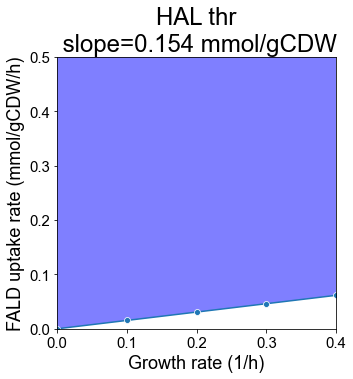

In [21]:
with HAL as m: 
    m.reactions.EX_thr__L_e.lower_bound = -1000
    HAL2_df = data.copy()
    req_calc(m,HAL2_df,'HAL thr')